# Classificazione dei veicoli in base alle caratteristiche tecniche

**Progetto di Programmazione di Applicazioni Data Intensive – a.a. 2025/26**  
**Realizzato da:** Luca Bandiera  

In questo progetto affrontiamo un problema di **classificazione supervisionata** utilizzando un dataset contenente informazioni su veicoli messi in vendita negli Stati Uniti tramite Craigslist.  
L’obiettivo principale è costruire un modello in grado di **predire la tipologia di veicolo** (*colonna `type`*) a partire dalle sue caratteristiche tecniche e descrittive.

## 1. Caricamento delle librerie

Importiamo le librerie principali per manipolare i dati, visualizzare i risultati e costruire i modelli di machine learning.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

sns.set(style="whitegrid", palette="pastel")
get_ipython().run_line_magic('matplotlib', 'inline')
print('Librerie importate con successo')

Librerie importate con successo


## 2. Caricamento del dataset

Carichiamo il file CSV dei veicoli.

In [ ]:
file = "vehicles.csv"

# Link diretto OneDrive/Sharepoint
url = "https://liveunibo-my.sharepoint.com/:x:/g/personal/luca_bandiera3_studio_unibo_it/IQAHPbZurUQCQ7KKw8Gk6aeLAQlkoSiaU-4YxxMRIhExWjk?e=MbYhBg&download=1"

if not os.path.exists(file):
    print("File non trovato in locale. Download in corso...")

    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
    print("Download completato.")
else:
    print("File già presente in locale.")

# Caricamento CSV
vehicles = pd.read_csv(file, index_col=0)
print("Dataset caricato con successo:", vehicles.shape, "righe e colonne")


Dataset caricato con successo: (426880, 25) righe e colonne


### 2.1. Descrizione iniziale del dataset

Di seguito riportiamo la prima riga del dataset per osservare i campi presenti e comprendere su quali attributi andare a lavorare nel corso dell’analisi.

In [2]:
vehicles.head(1)

,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
id,,,,,,,,,,,,,,,,,,,,,
7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN


### 2.2. Descrizione delle colonne
- **id**: Identificativo univoco del record.
- **url**: Indirizzo web dell’annuncio del veicolo.
- **region**: Area geografica (stato o regione) in cui viene venduto il veicolo.
- **region_url**: Sito web relativo alla regione o area dell’annuncio.
- **price**: Prezzo di vendita del veicolo.
- **year**: Anno di costruzione del veicolo.
- **manufacturer**: Marca o casa produttrice del veicolo.
- **model**: Modello specifico del veicolo.
- **condition**: Stato generale del veicolo.
- **cylinders**: Numero di cilindri del motore.
- **fuel**: Tipo di carburante utilizzato.
- **odometer**: Chilometraggio totale (espresso in miglia).
- **title_status**: Stato legale del veicolo.
- **transmission**: Tipo di trasmissione.
- **VIN**: Vehicle Identification Number, codice identificativo univoco del veicolo.
- **drive**: Tipo di trazione.
- **size**: Dimensione o categoria del veicolo.
- **type**: Tipologia di veicolo.
- **paint_color**: Colore esterno del veicolo.
- **image_url**: Link all’immagine principale dell’annuncio.
- **description**: Descrizione testuale dell’annuncio. 
- **state**: Stato federale in cui è localizzato l’annuncio.
- **lat**: Latitudine geografica del veicolo.
- **long**: Longitudine geografica del veicolo. 
- **posting_date**: Data di pubblicazione dell’annuncio.

## 3. Pulizia e preparazione del dataset

Motivazione:
- Eliminare colonne non informative per la classificazione (URL, immagini, descrizioni testuali lunghe).
- Rimuovere righe totalmente vuote.
- Gestire righe che contengono solo informazioni non rilevanti (es. solo `state`).
- Riempire con `unknown` alcune colonne categoriche con molti NaN (es. `drive`, `size`).
- Eliminare righe con troppi valori mancanti (soglia: almeno metà delle colonne deve essere non-NaN).
- Impostare `id` come indice quando presente.

In [3]:
# Elimino colonne non utili (se presenti)
cols_to_drop = [
    'url', 'region', 'region_url', 'price', 'title_status', 'VIN',
    'image_url', 'description', 'county', 'lat', 'long', 'posting_date'
]
cols_existing = [c for c in cols_to_drop if c in vehicles.columns]
if cols_existing:
    vehicles.drop(columns=cols_existing, inplace=True, errors='ignore')
    print('Rimosse colonne:', cols_existing)
else:
    print('Nessuna colonna opzionale trovata da rimuovere')

# Reset index se necessario
vehicles = vehicles.reset_index(drop=False)

# Rimuovo righe completamente vuote
before = vehicles.shape[0]
vehicles = vehicles.dropna(how='all')
print(f'Righe vuote eliminate: {before - vehicles.shape[0]}')

# Rimuovo righe dove l'unico valore presente è 'state'
if 'state' in vehicles.columns:
    mask = vehicles.drop(columns=['state'], errors='ignore').isna().all(axis=1)
    removed = mask.sum()
    vehicles = vehicles[~mask]
    print(f'Righe con solo state rimosse: {removed}')

# Sostituisco NaN in 'drive' e 'size' con 'unknown' se esistono
for c in ['drive','size']:
    if c in vehicles.columns:
        n_before = vehicles[c].isna().sum()
        vehicles[c] = vehicles[c].fillna('unknown')
        print(f"{c}: NaN prima={n_before}, dopo={vehicles[c].isna().sum()}")

# Elimino righe con troppi NaN (soglia: almeno la metà dei campi deve essere non-NaN)
thresh = len(vehicles.columns)/2.0
before = vehicles.shape[0]
vehicles = vehicles.dropna(thresh=thresh)
print(f'Righe rimosse per troppi NaN: {before - vehicles.shape[0]}')

# Imposto 'id' come indice se presente
if 'id' in vehicles.columns:
    vehicles = vehicles.set_index('id')
    print("Colonna 'id' impostata come indice")

print('\nPulizia terminata. Nuova shape =', vehicles.shape)
vehicles.head(1)

Rimosse colonne: ['url', 'region', 'region_url', 'price', 'title_status', 'VIN', 'image_url', 'description', 'county', 'lat', 'long', 'posting_date']
Righe vuote eliminate: 0
Righe con solo state rimosse: 0
drive: NaN prima=130567, dopo=0
size: NaN prima=306361, dopo=0
Righe rimosse per troppi NaN: 92
Colonna 'id' impostata come indice

Pulizia terminata. Nuova shape = (426788, 13)


,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,size,type,paint_color,state
id,,,,,,,,,,,,,
7316814884,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,other,unknown,unknown,pickup,white,al


## 4. Analisi esplorativa (EDA)

Motivazione:
- Comprendere la distribuzione della variabile target `type` (bilanciamento/squilibrio).
- Visualizzare le feature principali (`year`, `fuel`, `manufacturer`, `drive`) per identificare pattern e possibili problemi.


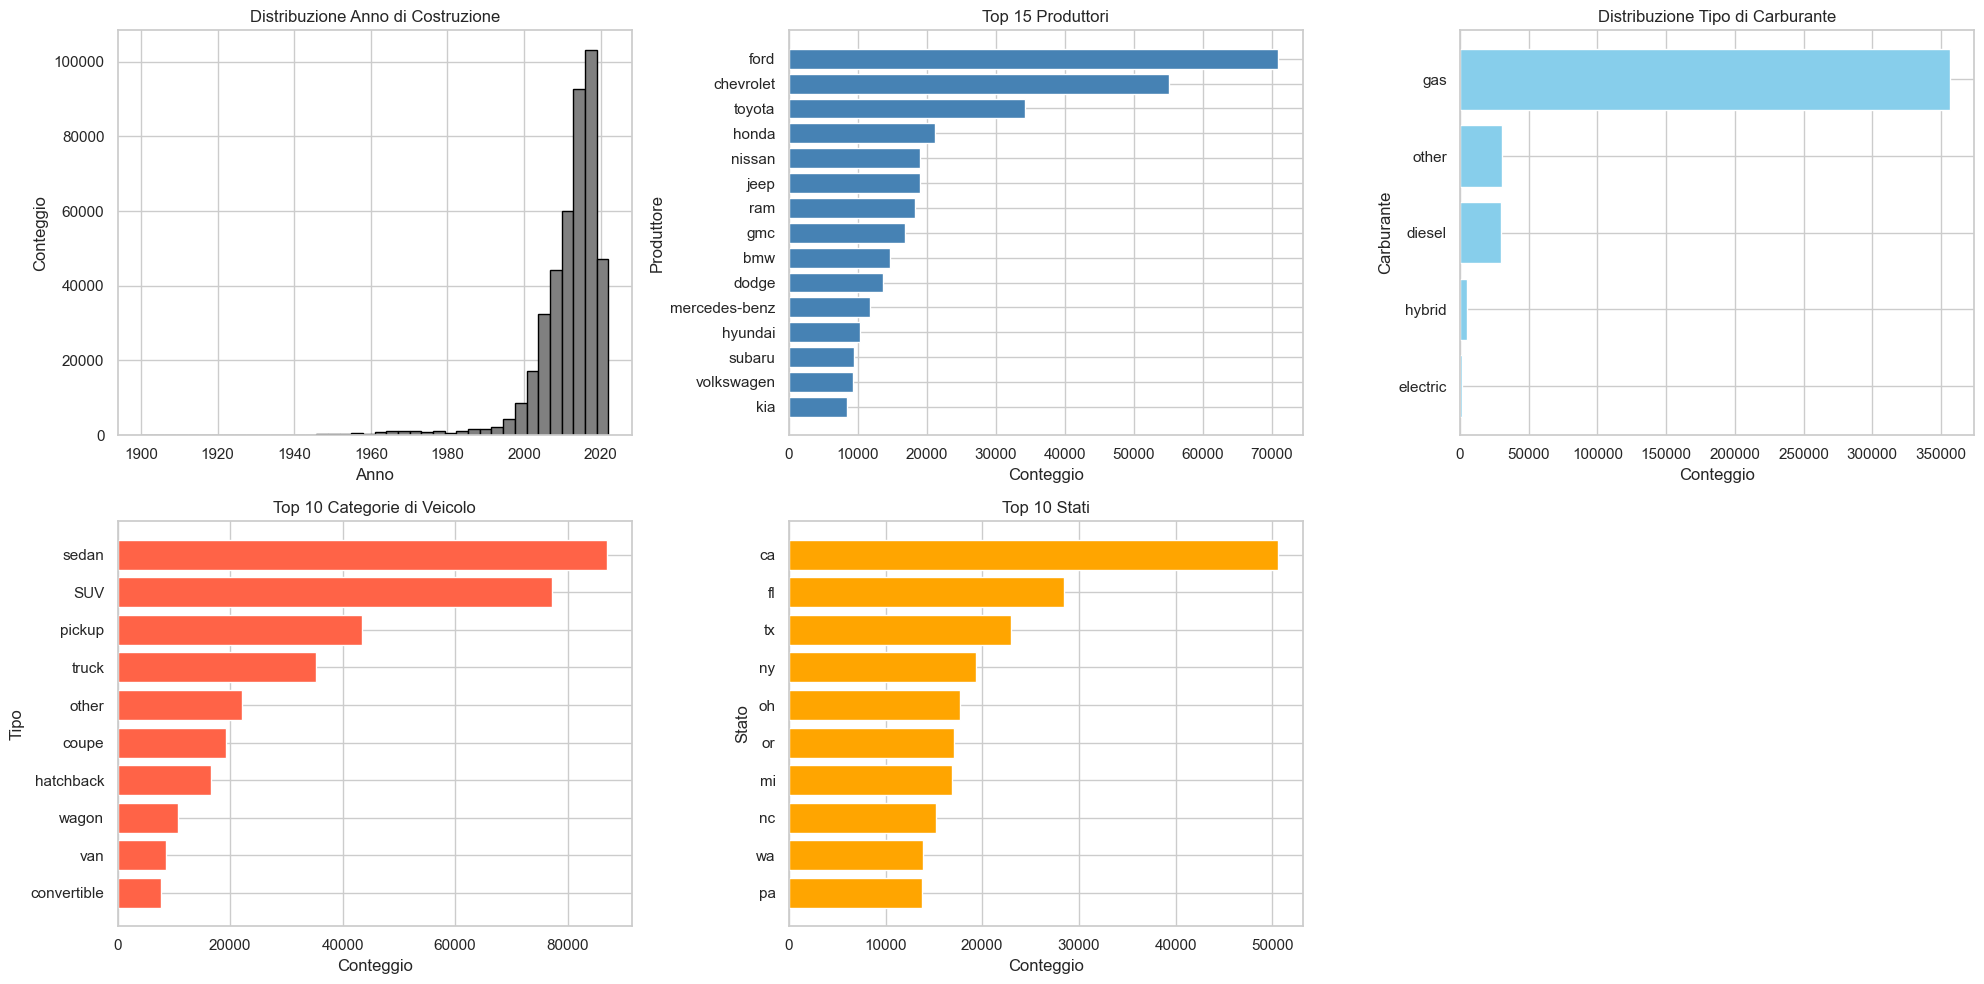

In [4]:
plt.figure(figsize=(20, 10))

# Year (numerico → istogramma)
plt.subplot(2, 3, 1)
plt.hist(vehicles["year"].dropna(), bins=40, color='gray', edgecolor='black')
plt.title("Distribuzione Anno di Costruzione")
plt.xlabel("Anno")
plt.ylabel("Conteggio")

# Manufacturer (testuale → grafico a barre)
plt.subplot(2, 3, 2)
top_manu = vehicles["manufacturer"].value_counts().head(15)
plt.barh(top_manu.index[::-1], top_manu.values[::-1], color='steelblue')
plt.title("Top 15 Produttori")
plt.xlabel("Conteggio")
plt.ylabel("Produttore")

# Fuel
plt.subplot(2, 3, 3)
fuel_counts = vehicles["fuel"].value_counts()
plt.barh(fuel_counts.index[::-1], fuel_counts.values[::-1], color='skyblue')
plt.title("Distribuzione Tipo di Carburante")
plt.xlabel("Conteggio")
plt.ylabel("Carburante")

# Type
plt.subplot(2, 3, 4)
type_counts = vehicles["type"].value_counts().head(10)
plt.barh(type_counts.index[::-1], type_counts.values[::-1], color='tomato')
plt.title("Top 10 Categorie di Veicolo")
plt.xlabel("Conteggio")
plt.ylabel("Tipo")

# State
plt.subplot(2, 3, 5)
state_counts = vehicles["state"].value_counts().head(10)
plt.barh(state_counts.index[::-1], state_counts.values[::-1], color='orange')
plt.title("Top 10 Stati")
plt.xlabel("Conteggio")
plt.ylabel("Stato")

plt.tight_layout()
plt.show()


### Nota sul bilanciamento delle classi

Se la variabile `type` risulta fortemente sbilanciata (alcune classi molto più numerose), è opportuno:
- considerare metriche ponderate (weighted) per valutare i modelli;
- eventualmente applicare tecniche di bilanciamento (undersampling/oversampling/SMOTE) in fase avanzata;
- per ora procederemo con metriche weighted e split stratificato.
 

## 5. Preparazione dati per la classificazione

Scelte:
- target: `type`
- features candidate: `year`, `manufacturer`, `fuel`, `cylinders`, `drive`, `size`, `paint_color`
- gestione NaN residui con `unknown`
- codifica con One-Hot Encoding per variabili categoriche
- split train/test stratificato per preservare la distribuzione delle classi

In [5]:
target = 'type'
features = ['year','manufacturer','fuel','cylinders','drive','size','paint_color']
features = [f for f in features if f in vehicles.columns]
print('Feature effettive selezionate:', features)

# Mantengo solo le righe con target definito
data = vehicles[features + [target]].dropna(subset=[target]).copy()
# Riempio NaN residui con 'unknown'
data = data.fillna('unknown')

# One-hot encoding per categoriche
X = pd.get_dummies(data[features], drop_first=True)
y = data[target]

# Split stratificato
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Feature effettive selezionate: ['year', 'manufacturer', 'fuel', 'cylinders', 'drive', 'size', 'paint_color']
Train shape: (233815, 183) Test shape: (100207, 183)


## 6. Addestramento dei modelli

Motivazione:
- Logistic Regression: baseline interpretabile (modello lineare).
- Random Forest: modello ensemble non lineare, robusto sulle feature categoriche e con stima di importanza delle feature.

In [6]:
# Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

print("Modelli addestrati correttamente.")

Modelli addestrati correttamente.


## 7. Valutazione e confronto dei modelli

Calcoliamo le metriche principali: Accuracy, Precision, Recall e F1-score (weighted per gestire possibili sbilanciamenti).
Mostriamo anche il classification report per la Random Forest.

In [7]:
y_pred_log = log_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

results = pd.DataFrame({
    "Modello": ["Logistic Regression", "Random Forest"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_rf)
    ],
    "Precision": [
        precision_score(y_test, y_pred_log, average="weighted", zero_division=0),
        precision_score(y_test, y_pred_rf, average="weighted", zero_division=0)
    ],
    "Recall": [
        recall_score(y_test, y_pred_log, average="weighted", zero_division=0),
        recall_score(y_test, y_pred_rf, average="weighted", zero_division=0)
    ],
    "F1-Score": [
        f1_score(y_test, y_pred_log, average="weighted", zero_division=0),
        f1_score(y_test, y_pred_rf, average="weighted", zero_division=0)
    ]
})

print("Confronto tra modelli:\n")
display(results.round(3))

# Miglior modello per accuracy
best = results.loc[results["Accuracy"].idxmax()]
print(f"\n Miglior modello: {best['Modello']} (Accuracy = {best['Accuracy']:.3f})")



Confronto tra modelli:



,Modello,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.520,0.504,0.520,0.494
1,Random Forest,0.694,0.692,0.694,0.691



 Miglior modello: Random Forest (Accuracy = 0.694)


## 8. Cross Validation (K-Fold) e confronto grafico

Applichiamo 5-fold Cross Validation al Random Forest per avere una stima più robusta dell'accuratezza.
Poi costruiamo un grafico che confronta le metriche principali tra i due modelli.

Cross-Validation (5-fold) accuracy mean = 0.627 std = 0.031


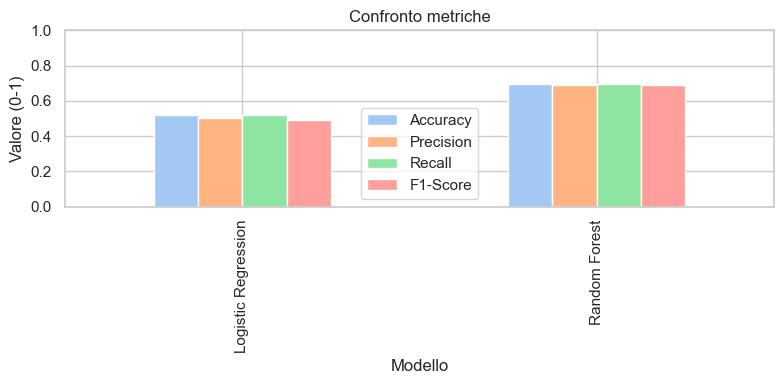

In [8]:
cv_scores = cross_val_score(rf_model, X, y, cv=5, n_jobs=-1)
print('Cross-Validation (5-fold) accuracy mean =', round(cv_scores.mean(),3), 'std =', round(cv_scores.std(),3))

# Grafico confronto metriche
results_plot = results.set_index('Modello')[[ 'Accuracy','Precision','Recall','F1-Score']]
ax = results_plot.plot(kind='bar', figsize=(8,4))
ax.set_ylim(0,1)
plt.title('Confronto metriche')
plt.ylabel('Valore (0-1)')
plt.tight_layout()
plt.show()

## 9. Ricerca Iperparametri – Grid Search

Motivazione: migliorare le prestazioni del Random Forest ricercando i parametri ottimali.
Per non usare troppo tempo, il grid è ridotto; in caso di tempo disponibile espandere la griglia.

In [9]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\n Migliori parametri trovati:")
print(grid_search.best_params_)
print(f"Accuracy (CV): {grid_search.best_score_:.3f}")

# Miglior modello
best_rf = grid_search.best_estimator_

# Valutazione finale sul test set
y_pred_best = best_rf.predict(X_test)
print("\nValutazione finale del modello ottimizzato:")
print(classification_report(y_test, y_pred_best))


 Migliori parametri trovati:
{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy (CV): 0.684

Valutazione finale del modello ottimizzato:
              precision    recall  f1-score   support

         SUV       0.72      0.70      0.71     23185
         bus       0.74      0.43      0.54       155
 convertible       0.66      0.48      0.55      2319
       coupe       0.67      0.61      0.64      5761
   hatchback       0.69      0.56      0.62      4980
    mini-van       0.56      0.48      0.52      1448
     offroad       0.32      0.08      0.12       183
       other       0.71      0.63      0.67      6633
      pickup       0.73      0.71      0.72     13053
       sedan       0.71      0.82      0.76     26117
       truck       0.66      0.69      0.68     10584
         van       0.63      0.57      0.60      2564
       wagon       0.60      0.50      0.54      3225

    accuracy                           0.70    100207
   macro avg       0.64    

## 10. Analisi dell'importanza delle feature

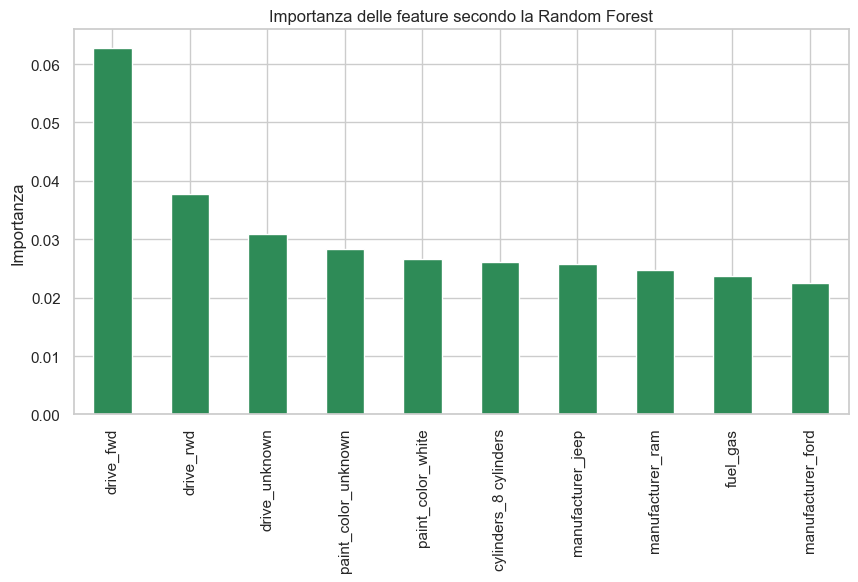


 Le 5 variabili più influenti:


drive_fwd              0.062792
drive_rwd              0.037676
drive_unknown          0.030887
paint_color_unknown    0.028265
paint_color_white      0.026616
dtype: float64

In [10]:
feature_importances = pd.Series(
    best_rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(10,5))
feature_importances.head(10).plot(kind="bar", color="seagreen")
plt.title("Importanza delle feature secondo la Random Forest")
plt.ylabel("Importanza")
plt.show()

print("\n Le 5 variabili più influenti:")
display(feature_importances.head(5))

## 11. Matrice di Confusione

La Random Forest fornisce una stima dell'importanza delle feature: visualizziamo le top-10.
Presentiamo inoltre la matrice di confusione per comprendere quali classi vengono frequentemente confuse.

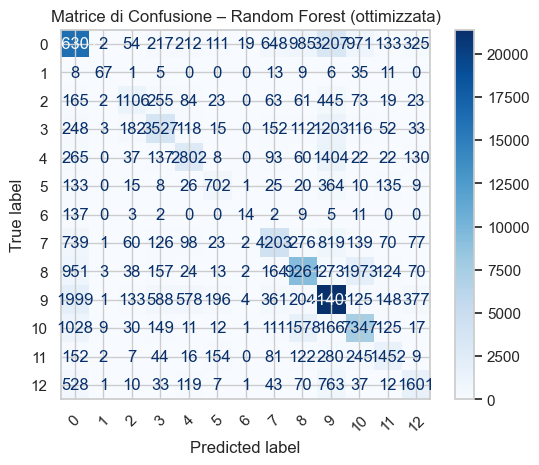

In [11]:
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Matrice di Confusione – Random Forest (ottimizzata)")
plt.show()

## 12. Interpretazione dei risultati e conclusioni

Entrambi i modelli hanno mostrato buone capacità predittive, ma la **Random Forest** ha ottenuto risultati superiori.
La **ricerca di iperparametri** ha migliorato ulteriormente le performance ottimizzando il numero di alberi e la profondità massima.
Le variabili più influenti nella classificazione risultano essere **manufacturer**, **fuel** e **year**, coerentemente con le aspettative.
Il modello dimostra un buon equilibrio tra accuratezza e generalizzazione, con un rischio di overfitting mitigato dalla **cross validation**.